In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
raw_data_pd = pd.read_table('data/tcr_ab_pairs.txt')
raw_data_pd.head()

,sample,clone,nSeqCDR3,aaSeqCDR3,allVGenes,allDGenes,allJGenes,positionOfCDR3Begin,positionOfVEndTrimmed,positionOfDBeginTrimmed,positionOfDEndTrimmed,positionOfJBeginTrimmed,chain
0,1,0,TGTGCAGCATTAGGTGGTTCTGCAAGGCAACTGACCTTT,CAALGGSARQLTF,TRAV29DV5,NaN,TRAJ22,48,57,-1,-1,62,A
1,1,0,TGTGCCAGCAGTTACGGAGCCCCCGGGACAGCCTTTTACGAGCAGT...,CASSYGAPGTAFYEQYF,"TRBV6-5,TRBV6-8,TRBV6-6,TRBV6-3,TRBV6-2","TRBD1,TRBD2",TRBJ2-7,36,51,57,67,72,B
2,1,2,TGTGCTGTGACCGATAGCAACTATCAGTTAATCTGG,CAVTDSNYQLIW,TRAV1-2,NaN,TRAJ33,51,61,-1,-1,63,A
3,1,2,TGCGCCAGCAGCCAAGATCGAGCGGGAGGGCCGGATACGCAGTATTTT,CASSQDRAGGPDTQYF,"TRBV4-3,TRBV4-2,TRBV4-1",TRBD2,TRBJ2-3,39,58,59,71,72,B
4,1,3,TGTGCTGTCACCCCCTTCAAAGCTGCAGGCAACAAGCTAACTTTT,CAVTPFKAAGNKLTF,TRAV41,NaN,TRAJ17,42,52,-1,-1,58,A


In [3]:
raw_clones_set = set(raw_data_pd['clone'])
clones_ab_presence = {x:[False, False] for x in raw_clones_set}
for clone in raw_data_pd['clone'][raw_data_pd['chain'] == 'A']:
    clones_ab_presence[clone][0] = True
for clone in raw_data_pd['clone'][raw_data_pd['chain'] == 'B']:
    clones_ab_presence[clone][1] = True

clones = set([])
for clone in raw_clones_set:
    if np.all(clones_ab_presence[clone]):
        clones.add(clone)

del raw_clones_set
del clones_ab_presence
clones_dict = {x:i for i, x in enumerate(clones)}

In [4]:
raw_data = raw_data_pd.as_matrix()
data = np.zeros((len(clones), 9), dtype=object)
for i in range(raw_data.shape[0]):
    clone =  raw_data[i, 1]
    if clone in clones:
        index = clones_dict[clone]
        if raw_data[i, -1] == 'A':
            data[index, :5] = raw_data[i, [1, 0, 3, 4, 6]]
        else:
            data[index, 5:] = raw_data[i, 3:7]
del raw_data
columns = ['clone', 'sample', 'alpha.cdr3', 'alpha.allVGenes', 'alpha.allJGenes', 
           'beta.cdr3', 'beta.allVGenes', 'beta.allDGenes', 'beta.allJGenes']
data_pd = pd.DataFrame(data, columns = columns)
data_pd.head()

,clone,sample,alpha.cdr3,alpha.allVGenes,alpha.allJGenes,beta.cdr3,beta.allVGenes,beta.allDGenes,beta.allJGenes
0,0,5,CAVNMDSSYKLIF,"TRAV12-1,TRAV12-2",TRAJ12,CASSLGTGNQPQHF,"TRBV7-2,TRBV7-8",TRBD1,TRBJ1-5
1,1,3,CAENTANNDMRF,TRAV13-2,TRAJ43,CASSFASVSGYTF,"TRBV12-4,TRBV12-3",NaN,TRBJ1-2
2,2,5,CAFMRWRDDKIIF,"TRAV38-2DV8,TRAV38-1",TRAJ30,CASSPTGPGDTQYF,"TRBV7-3,TRBV7-9,TRBV7-4","TRBD2,TRBD1",TRBJ2-3
3,3,5,CAFMRWRDDKIIF,"TRAV38-2DV8,TRAV38-1",TRAJ30,CASSLGGGRNQPQHF,"TRBV7-2,TRBV7-8","TRBD1,TRBD2",TRBJ1-5
4,4,5,CAVGPQAAGNKLTF,TRAV8-3,TRAJ17,CASSATGTGHSPLHF,TRBV7-9,TRBD1,TRBJ1-6


In [5]:
data_pd = data_pd[['alpha.cdr3', 'beta.cdr3']]
data = data_pd.as_matrix()
data_pd.head()

,alpha.cdr3,beta.cdr3
0,CAVNMDSSYKLIF,CASSLGTGNQPQHF
1,CAENTANNDMRF,CASSFASVSGYTF
2,CAFMRWRDDKIIF,CASSPTGPGDTQYF
3,CAFMRWRDDKIIF,CASSLGGGRNQPQHF
4,CAVGPQAAGNKLTF,CASSATGTGHSPLHF


In [6]:
alpha_ind = [5 < len(data[i, 0]) < 16 for i in range(data.shape[0])]
beta_ind = [5 < len(data[i, 1]) < 16 for i in range(data.shape[0])]
indexes = np.all([alpha_ind, beta_ind], axis=0)
ldata = data[indexes]

In [7]:
def standartize_cdr3_length(protein):
    insertion_places = {6:3, 7:4, 8:4, 9:5, 10:5, 11:6, 12:6, 13:7, 14:7, 15:8}
    insertion_place = insertion_places[len(protein)]
    insertion_length = 15 - len(protein)
    return protein[:insertion_place] + '_' * insertion_length + protein[insertion_place:]

In [8]:
for i in range(ldata.shape[0]):
    ldata[i, 0] = standartize_cdr3_length(ldata[i, 0])
    ldata[i, 1] = standartize_cdr3_length(ldata[i, 1])

In [9]:
aa = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '_']
aa2num_table = {aa[i]:i for i in range(21)}

def aa2num(aa):
    return aa2num_table[aa]

def protein2array(protein):
    return np.array([aa2num(aa) for aa in protein])

In [10]:
for i in range(ldata.shape[0]):
    ldata[i, 0] = protein2array(ldata[i, 0])
    ldata[i, 1] = protein2array(ldata[i, 1])

In [11]:
def GetPairSampling(A, B):
    assert A.shape[0] % 2 == 0
    X = np.zeros((2 * A.shape[0], A.shape[1] + B.shape[1]))
    X[::2, :A.shape[1]] = A
    X[1::2, :A.shape[1]] = A
    X[::2, A.shape[1]:] = B
    X[1::4, A.shape[1]:] = B[1::2]
    X[3::4, A.shape[1]:] = B[::2]
    
    y = np.zeros((2 * A.shape[0]))
    y[::2] = 1
    
    return X, y

In [12]:
A = np.array([list(x) for x in ldata[:-1, 0]])
B = np.array([list(x) for x in ldata[:-1, 1]])

In [57]:
strikeness = np.zeros((A.shape[0], 4), dtype=int)
columns=['overall', 'tp', 'tn.alpha', 'tn.beta']

In [60]:
for i in range(1000):
    if i % 10 == 0:
        print(i, end=' ')
    
    train_index, test_index = train_test_split(np.arange(A.shape[0]))
    train_size, test_size = train_index.shape[0], test_index.shape[0]

    X_train, y_train = GetPairSampling(A[train_index], B[train_index])
    X_test, y_test = GetPairSampling(A[test_index], B[test_index])
    
    rf = RandomForestClassifier(n_estimators=25)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    score = y_pred == y_test
    
    strikeness[test_index, 0] += 1
    strikeness[test_index, 1] += score[::2]
    strikeness[test_index, 2] += score[1::2]
    strikeness[test_index[::2], 3] += score[3::4]
    strikeness[test_index[1::2], 3] += score[1::4]

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 

In [62]:
pd.DataFrame(strikeness).to_csv('strikeness1000.csv')

In [ ]:
for i in range(1000):
    if i % 10 == 0:
        print(i, end=' ')
    pair_train_index, pair_test_index = train_test_split(np.arange(X.shape[0] // 2))
    train_index = np.concatenate([2 * pair_train_index, 1 + 2 * pair_train_index], axis=0)
    test_index = np.concatenate([2 * pair_test_index, 1 + 2 * pair_test_index], axis=0)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rf = RandomForestClassifier(n_estimators=25)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    score = y_pred == y_test
    
    goodness[test_index, 0] += score
    goodness[test_index, 1] += 1

In [30]:
pd.DataFrame(goodness).to_csv('goodness3000.csv')

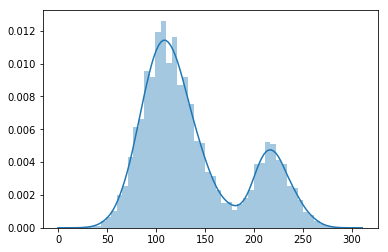

In [70]:
sns.distplot(strikeness[:, 1])

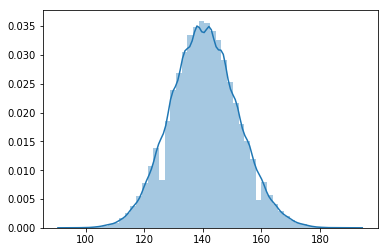

In [71]:
sns.distplot(strikeness[:, 2])

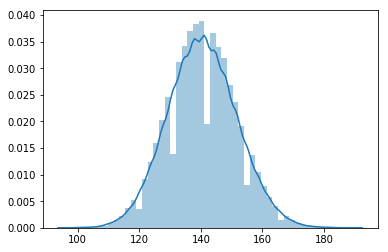

In [72]:
sns.distplot(strikeness[:, 3])

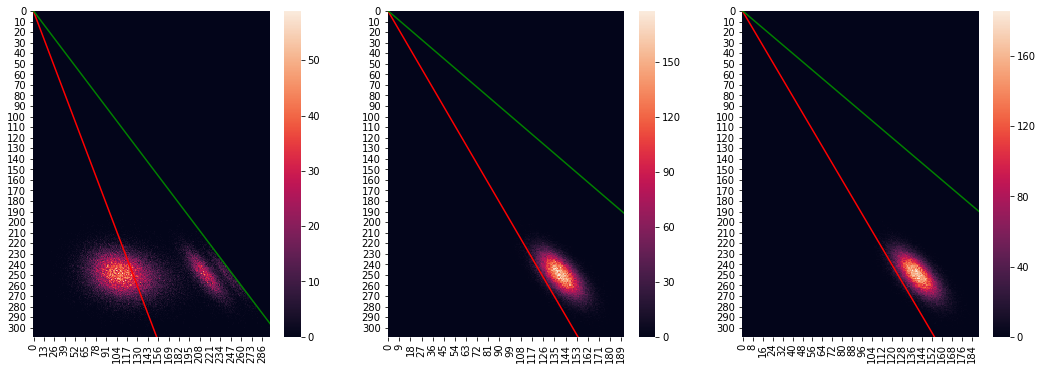

In [93]:
ax = plt.figure(figsize=(18, 6)).subplots(ncols=3)
i = 0
for j_ in range(3):
    j = j_ + 1
    t = np.zeros((1 + np.max(strikeness[:, i]), 1 + np.max(strikeness[:, j])))
    for k in range(strikeness.shape[0]):
        t[strikeness[k, i], strikeness[k, j]] += 1
    sns.heatmap(t, ax=ax[j_])
    if t.shape[0] > t.shape[1] * 2:
        ax[j_].plot([0, t.shape[0] / 2 + 5], [0, 10 + t.shape[0]], color='red')
        ax[j_].plot([0, 10 + t.shape[0]], [0, 10 + t.shape[0]], color='green')
    else:
        ax[j_].plot([0, t.shape[1] + 5], [0, 10 + 2 * t.shape[1]], color='red')
        ax[j_].plot([0, 10 + 2 * t.shape[1]], [0, 10 + 2 * t.shape[1]], color='green')

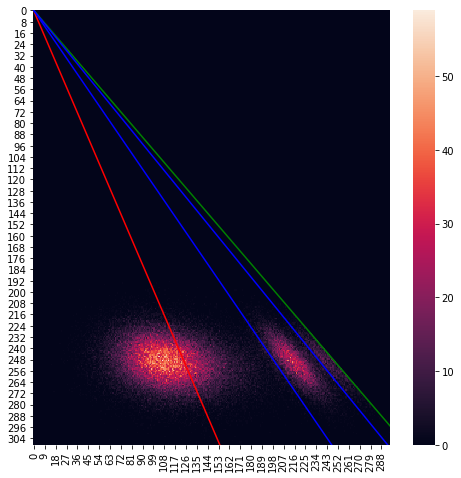

In [108]:
ax = plt.figure(figsize=(8, 8)).subplots()
i = 0
j = 1
t = np.zeros((1 + np.max(strikeness[:, i]), 1 + np.max(strikeness[:, j])))
for k in range(strikeness.shape[0]):
    t[strikeness[k, i], strikeness[k, j]] += 1
sns.heatmap(t, ax=ax)
ax.plot([0, t.shape[1] + 5], [0, 10 + 2 * t.shape[1]], color='red')
ax.plot([0, 10 + 2 * t.shape[1]], [0, 10 + 2 * t.shape[1]], color='green')
ax.plot([0, 0.8 * (10 + 2 * t.shape[1])], [0, 10 + 2 * t.shape[1]], color='blue')
ax.plot([0, 0.95 * (10 + 2 * t.shape[1])], [0, 10 + 2 * t.shape[1]], color='blue')

In [109]:
cluster = np.array(strikeness[:, 1] > 0.8 * strikeness[:, 0], dtype=int) +\
np.array(strikeness[:, 1] > 0.95 * strikeness[:, 0], dtype=int)

In [115]:
X = np.concatenate([A, B], axis=1)
train_index, test_index = train_test_split(np.arange(A.shape[0]))
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = cluster[train_index], cluster[test_index]

rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [116]:
t = np.zeros((3, 3), dtype=int)
for i in range(test_index.shape[0]):
    t[y_test[i], y_pred[i]] += 1
pd.DataFrame(t)

,0,1,2
0,22970,60,0
1,1538,3636,24
2,78,23,967
